<a href="https://colab.research.google.com/github/willyptrain/cs4774-mask-detection/blob/main/copy_of_cs_4774_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

# import shutil
# shutil.rmtree('images/')
# shutil.rmtree('annotations/')

!unzip -q 'drive/My Drive/face_mask_detection.zip' 


Mounted at /content/drive/


In [2]:
import torchvision
import glob
import os
from bs4 import BeautifulSoup
import numpy as np
import shutil
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset
from PIL import Image
import torch
import matplotlib
import cv2
import matplotlib.patches as patches
from torch.utils.data import SubsetRandomSampler




In [3]:
# shutil.rmtree('train/')
# shutil.rmtree('val/')
# shutil.rmtree('test/')


os.makedirs('train/images')
os.makedirs('train/annotations')
os.makedirs('val/images')
os.makedirs('val/annotations')
os.makedirs('test/images')
os.makedirs('test/annotations')

In [4]:


def load_train_split_paths(directory):
  img_paths = glob.iglob(directory)
  path_bases = []
  original_files = []
  for path in img_paths:
    # print(path, path.split("/")[1].rstrip(".png"))
    path_bases.append(path.split("/")[1].rstrip(".png"))


  # print('maksssksksss0' in path_bases)
  # path_bases = sorted(path_bases, key = lambda x: int(x.split("maksssksksss")[1]))
  # for val in path_bases:
  #   print(original_files.index(val), original_files[original_files.index(val)])
  # # print(int(x[0].split("maksssksksss")[1]))
  # print(path_bases)
  

  train_paths = path_bases[0:800]
  val_paths = path_bases[800:840]
  test_paths = path_bases[840:]

  # train_paths += val_paths
  # val_paths = []

  print("Training size:", len(train_paths))
  print("Validation size:", len(val_paths))
  print("Testing size:", len(test_paths))
  return train_paths, val_paths, test_paths

train_paths, val_paths, test_paths = load_train_split_paths("images/*")



Training size: 800
Validation size: 40
Testing size: 13


In [5]:
print("starting move")
for path in train_paths:
  img_path = os.path.join('images/', path+".png")
  annot_path = os.path.join('annotations/', path+".xml")
  shutil.move(img_path, 'train/images')
  shutil.move(annot_path, 'train/annotations')

print("ending train move, starting val")

for path in val_paths:
  img_path = os.path.join('images/', path+".png")
  annot_path = os.path.join('annotations/', path+".xml")
  shutil.move(img_path, 'val/images')
  shutil.move(annot_path, 'val/annotations')

print("ending val move, starting test")

for path in test_paths:
  img_path = os.path.join('images/', path+".png")
  annot_path = os.path.join('annotations/', path+".xml")
  shutil.move(img_path, 'test/images')
  shutil.move(annot_path, 'test/annotations')

print("finished moving")


starting move
ending train move, starting val
ending val move, starting test
finished moving


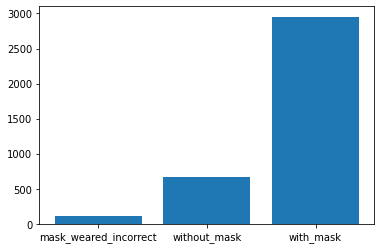

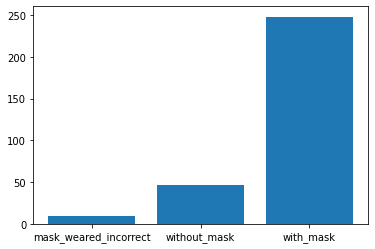

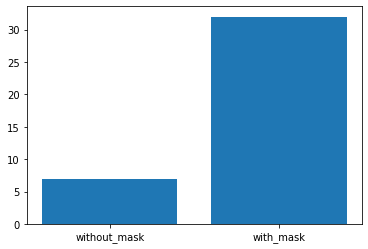

In [6]:
def read_annotations(base_dir, paths):
  label_mappings = {"with_mask": 2, "mask_weared_incorrect": 1, "without_mask":0} #0 for background class, not used 
  annotation_set = {}
  y = []
  y_labels = []
  y_boxes = []
  literal_labels = []
  for path in paths:
    xml_path = os.path.join(base_dir, path) + ".xml"
    with open(xml_path) as f:
      contents = f.read()
    xml_read = BeautifulSoup(contents, "xml")
    
    classes = []
    boxes = []

    truth_detections = xml_read.find_all("object")
    for obj in truth_detections:
      xmin = int(obj.find('xmin').text)
      xmax = int(obj.find('xmax').text)
      ymin = int(obj.find('ymin').text)
      ymax = int(obj.find('ymax').text)
      boxes.append([xmin, ymin, xmax, ymax])
      if(obj.find('name').text in label_mappings):
        classes.append(label_mappings[obj.find('name').text])
        literal_labels.append(obj.find('name').text)
      else: 
        literal_labels.append("N/A")
        classes.append(-1)

    classes = np.array(classes)
    boxes = np.array(boxes)
    y_boxes.append(boxes)
    y_labels.append(classes)
  

    annotation_set[path] = {
        'classes':classes, 
        'boxes':boxes
    }

    y.append([classes, boxes])
  
  y_boxes = np.array(y_boxes)
  y_labels = np.array(y_labels)
  return annotation_set, y_boxes, y_labels, literal_labels


train_annotation_set, y_train_boxes, y_train_labels, train_literal_labels = read_annotations('train/annotations/', train_paths)
val_annotation_set, y_val_boxes, y_val_labels, val_literal_labels = read_annotations('val/annotations/', val_paths)
test_annotation_set, y_test_boxes, y_test_labels, test_literal_labels = read_annotations('test/annotations/', test_paths)



frequency_unique_labels = Counter(train_literal_labels)
frequency_unique_labels = sorted(frequency_unique_labels.items(), key=lambda x: x[1])
plt.bar([i[0] for i in frequency_unique_labels], [i[1] for i in frequency_unique_labels])
plt.show()

frequency_unique_labels = Counter(val_literal_labels)
frequency_unique_labels = sorted(frequency_unique_labels.items(), key=lambda x: x[1])
plt.bar([i[0] for i in frequency_unique_labels], [i[1] for i in frequency_unique_labels])
plt.show()

frequency_unique_labels = Counter(test_literal_labels)
frequency_unique_labels = sorted(frequency_unique_labels.items(), key=lambda x: x[1])
plt.bar([i[0] for i in frequency_unique_labels], [i[1] for i in frequency_unique_labels])
plt.show()



tensor([[[0.5373, 0.5412, 0.5412,  ..., 0.8941, 0.9059, 0.9098],
         [0.5451, 0.5490, 0.5490,  ..., 0.8980, 0.9098, 0.9098],
         [0.5490, 0.5529, 0.5490,  ..., 0.9020, 0.9098, 0.9176],
         ...,
         [0.1961, 0.1804, 0.1529,  ..., 0.1373, 0.1373, 0.1333],
         [0.2000, 0.1804, 0.1529,  ..., 0.1373, 0.1373, 0.1373],
         [0.2000, 0.1804, 0.1529,  ..., 0.1373, 0.1373, 0.1373]],

        [[0.5333, 0.5412, 0.5373,  ..., 0.8902, 0.9059, 0.9137],
         [0.5451, 0.5451, 0.5490,  ..., 0.8941, 0.9059, 0.9137],
         [0.5490, 0.5490, 0.5451,  ..., 0.8980, 0.9098, 0.9216],
         ...,
         [0.1922, 0.1725, 0.1451,  ..., 0.1333, 0.1333, 0.1333],
         [0.1961, 0.1765, 0.1490,  ..., 0.1373, 0.1373, 0.1373],
         [0.1922, 0.1765, 0.1490,  ..., 0.1373, 0.1373, 0.1373]],

        [[0.5529, 0.5608, 0.5608,  ..., 0.8706, 0.8863, 0.8941],
         [0.5647, 0.5647, 0.5686,  ..., 0.8745, 0.8863, 0.8941],
         [0.5686, 0.5686, 0.5647,  ..., 0.8824, 0.8902, 0.

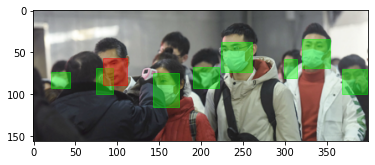

In [7]:

class FaceMaskDataset(Dataset):
  def __init__(self, base_dir, annotation_set, labels, images,transform=None):
    self.base_dir = base_dir
    self.annotation_set = annotation_set #boxes and classes dictionary from read_annotations()
    self.transform = transform #in case data needs to be transformed to torch tensor before fed into model
    self.labels = [i for i in glob.iglob(os.path.join(base_dir,'annotations/*'))]
    self.images = [i for i in glob.iglob(os.path.join(base_dir,'images/*'))]

  def __getitem__(self, idx):
    if(torch.is_tensor(idx)):
      idx = idx.tolist()

    image_path = os.path.join(os.path.join(self.base_dir,'images'), 'maksssksksss'+str(idx)+".png")
    image = Image.open(image_path).convert("RGB")

    # print("yo from inside", self.annotation_set.keys())
    boxes = self.annotation_set['maksssksksss'+str(idx)]['boxes']

    labels = self.annotation_set['maksssksksss'+str(idx)]['classes']
    sample = {
        'image_id': torch.tensor([idx]),#self.transform([image_path]),
        'boxes':self.transform(boxes)[0],
        'labels': torch.as_tensor(np.array(labels))
    }

    # sample = self.transform(image)

    return self.transform(image), sample



  def __len__(self):
    return len(self.labels)



tensor_transform = transforms.Compose([
    transforms.ToTensor(),
]) #transforms data to work with torchvision model


train_mask_dataset = FaceMaskDataset(base_dir='train/',annotation_set=train_annotation_set, labels=y_train_labels, images=train_paths ,transform=tensor_transform)
val_mask_dataset = FaceMaskDataset(base_dir='val/',annotation_set=val_annotation_set, labels=y_val_labels, images=val_paths ,transform=tensor_transform)
test_mask_dataset = FaceMaskDataset(base_dir='test/',annotation_set=test_annotation_set, labels=y_test_labels, images=test_paths, transform=tensor_transform)

test = train_mask_dataset[1]

def plot_box(sample):
  # print(sample)
  img = sample[0]
  print(img)
  boxes = sample[1]['boxes']
  labels = sample[1]['labels']
  fig,ax = plt.subplots(1)
  ax.imshow(np.transpose(img,(1,2,0)))
  for i, box in enumerate(boxes):
    xmin, ymin, xmax, ymax = box
    color = (1,0,0,0.4) if (labels[i] == 1 or labels[i] == 0) else (0,1,0,0.4)
    rect = matplotlib.patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,edgecolor=color,facecolor=color)
    ax.add_patch(rect)

  plt.show()  

plot_box(test)


In [8]:

train_size = 800
train_indices = [int(path.lstrip("maksssksksss").rstrip(".png")) for path in list(os.listdir('train/images/'))[:-1]]
train_sampler = SubsetRandomSampler(train_indices)

val_indices = [int(path.lstrip("maksssksksss").rstrip(".png")) for path in list(os.listdir('val/images/'))[:-1]]
val_sampler = SubsetRandomSampler(val_indices)

test_indices = [int(path.lstrip("maksssksksss").rstrip(".png")) for path in list(os.listdir('test/images/'))[:-1]]
test_sampler = SubsetRandomSampler(test_indices)



In [9]:
#With help from: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) #loads the Faster R-CNN model trained on the COCO dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features


num_classes = 3 #ORIGINALLY 3

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) #number of classes = 3 : with_mask, without_mask, mask_not_worn_corrected

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #loads the gpu if available to speed up training




#SOURCE: 
def collate_fn(batch):
    return tuple(zip(*batch)) #batches loaded and zipped to be unpacked as img, annotations
batch_size = 4

train_dataLoader = torch.utils.data.DataLoader(
        train_mask_dataset, batch_size=batch_size, num_workers=4, sampler=train_sampler, collate_fn=collate_fn)

val_dataLoader = torch.utils.data.DataLoader(
        val_mask_dataset, batch_size=1, shuffle=False, num_workers=4, sampler=val_sampler, collate_fn=collate_fn)

test_dataLoader = torch.utils.data.DataLoader(
        test_mask_dataset, batch_size=1, shuffle=False, num_workers=4, sampler=test_sampler, collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# for i in train_mask_dataset:
# print(i)


# print(len(train_mask_dataset))



Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


Batch size 4
Learning Rate 0.005

1 \ 20 Epoch
Training Loss: 67.26914978027344
Validation Loss: 11.395055770874023
Elapsed Time:  2.875383480389913 minutes,  52.523008823394775 seconds

2 \ 20 Epoch
Training Loss: 45.73487091064453
Validation Loss: 10.92799186706543
Elapsed Time:  2.877563953399658 minutes,  52.65383720397949 seconds

3 \ 20 Epoch
Training Loss: 39.178279876708984
Validation Loss: 10.37019157409668
Elapsed Time:  2.844183158874512 minutes,  50.6509895324707 seconds

4 \ 20 Epoch
Training Loss: 34.20690155029297
Validation Loss: 9.889948844909668
Elapsed Time:  2.8609677076339723 minutes,  51.65806245803833 seconds

5 \ 20 Epoch
Training Loss: 29.64680290222168
Validation Loss: 9.381624221801758
Elapsed Time:  2.8760953346888223 minutes,  52.565720081329346 seconds

6 \ 20 Epoch
Training Loss: 27.044546127319336
Validation Loss: 10.669705390930176
Elapsed Time:  2.8501155694325764 minutes,  51.00693416595459 seconds

7 \ 20 Epoch
Training Loss: 24.48456573486328
Valida

TypeError: ignored

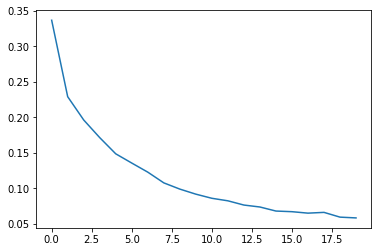

In [10]:

num_epochs = 20
model.to(device)
    
# parameters
l_rate = 0.005
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=l_rate, momentum=0.9, weight_decay=0.0005)#, nesterov-#weight_decay=0.0005) 

len_dataloader = len(train_dataLoader) #equal to size of dataset / batch size !

print("Batch size", batch_size)
print("Learning Rate", l_rate)
print()







train_loss = []
val_loss_arr = []



index = 0
total_start = time.time()
for epoch in range(num_epochs):
    model.train()
    i = 0
    index += 1    
    epoch_loss = 0
    print(index, "\\", num_epochs, "Epoch")
    start = time.time()
    for x, y in train_dataLoader:
        i += 1
        optimizer.zero_grad()
        x = [img.to(device) for img in x]
        y = [{k: v.to(device) for k, v in annot.items()} for annot in y]
        all_losses = model(x, y)#[imgs[0]], [annotations[0]])
        losses = sum(v for k,v in all_losses.items())        
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
        

          
    
    
    print("Training Loss:", epoch_loss.item())# * 100 / len(train_dataLoader))
    val_loss = 0
    for x, y in val_dataLoader:
      with torch.no_grad():
        x = list(img.to(device) for img in x)
        y = [{k: v.to(device) for k, v in t.items()} for t in y]
        val_loss_dict = model(x, y)
        val_losses = sum(loss for loss in val_loss_dict.values())         
        val_loss += val_losses
    print("Validation Loss:", val_loss.item())# * 100 / len(val_dataLoader))
    end = time.time()
    diff = end - start
    print("Elapsed Time: ", str(diff / 60), "minutes, ", str(diff % 60), "seconds")
    print()
    train_loss.append(epoch_loss.item() / len(train_dataLoader))
    val_loss_arr.append(val_loss.item() / len(val_dataLoader))
  
final_end = time.time()
total_diff = final_end - total_start
print("Total Training Time: ", str(total_diff / 360), "hours, ", str((total_diff % 360) / 60), "minutes")


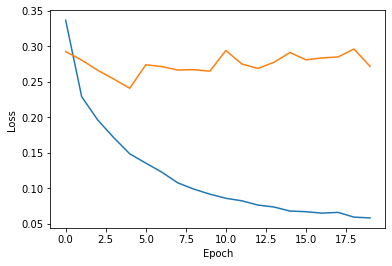

In [11]:


plt.plot([i for i in range(0, len(train_loss))],train_loss, label="training_loss")
plt.plot([i for i in range(0, len(val_loss_arr))],val_loss_arr, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


0.9988762736320496 with_mask
0.9985778331756592 with_mask


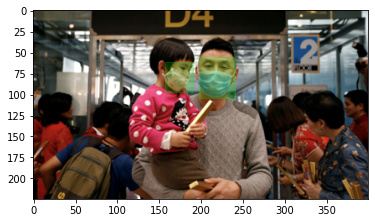

0.9989885687828064 with_mask
0.926945149898529 with_mask
0.6635024547576904 mask_weared_incorrect


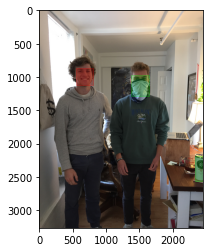

In [17]:
 
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1) 
    img = img_tensor.cpu().data

    label_mappings = {"with_mask": 2, "mask_weared_incorrect": 1, "without_mask":0} #0 for background class, not used 
    label_tags = ["without_mask", "mask_weared_incorrect", "with_mask"]
    
    ax.imshow(img.permute(1, 2, 0))
    
    for i, box in enumerate(annotation["boxes"]):
        xmin, ymin, xmax, ymax = box

        #SHOULD USE OPENCV DNN NMSBOXES => Eliminates problem of overlapping boxes
        if(float(annotation["scores"][i]) > 0.5):   
          print(float(annotation["scores"][i]), label_tags[annotation["labels"][i].item()])       
          color = (0,1,0,0.1) if (annotation["labels"][i] == 2) else (1,0,0,0.1)
          rect = matplotlib.patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,edgecolor=color,facecolor=color)
          ax.add_patch(rect)

          # Add the patch to the Axes
          ax.add_patch(rect)

    plt.show()


for test_imgs, test_annotations in test_dataLoader:
        test_imgs = list(img.to(device) for img in test_imgs)
        test_annotations = [{k: v.to(device) for k, v in t.items()} for t in test_annotations]
        break

model.eval()



test = test_imgs[0]
test = test.to(device)
preds = model([test])
preds
plot_image(test, preds[0])


test = Image.open('one_mask_no_mask.JPG').convert("RGB")#.rotate(270)
test = tensor_transform(test)

# test = test_imgs[0]
test = test.to(device)
preds = model([test])
preds
plot_image(test, preds[0])

# test = Image.open('mask.JPG').convert("RGB")#.rotate(270)
# test = tensor_transform(test)

# # test = test_imgs[0]
# test = test.to(device)
# preds = model([test])
# preds
# plot_image(test, preds[0])



In [14]:
torch.save(model.state_dict(), 'final_rcnn.zip')
!mv 'final_rcnn.zip' 'drive/My Drive/final_rcnn.zip'

0.5349510908126831 mask_weared_incorrect


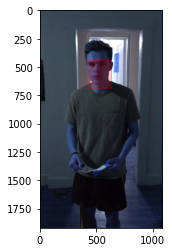

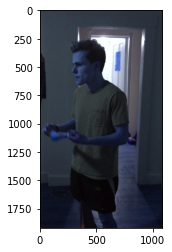

0.9809914231300354 with_mask


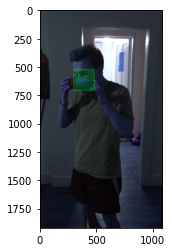

0.9986681938171387 with_mask


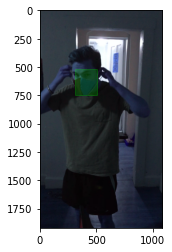

0.997408926486969 with_mask


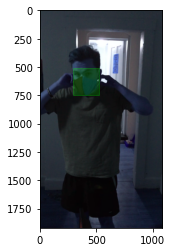

0.9995226860046387 with_mask


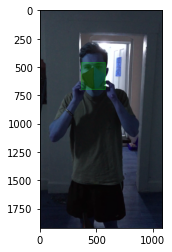

0.9995447993278503 with_mask


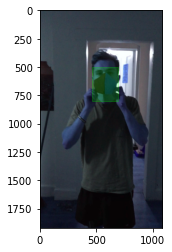

0.9993401169776917 with_mask


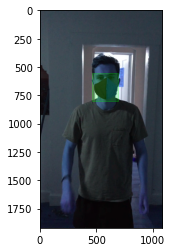

0.9989988207817078 with_mask


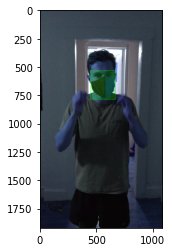

0.9993880987167358 with_mask


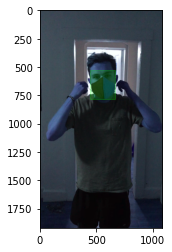

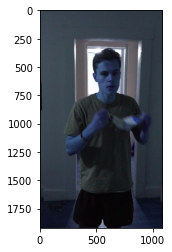

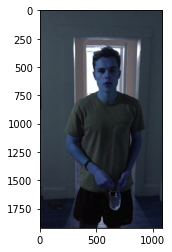

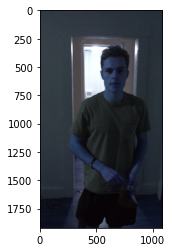

In [16]:
# model.eval()
frame_count = 0
frames = []
capture = cv2.VideoCapture('IMG_0157.mp4')  
step = 20  
while True:
    ret, frame = capture.read()
    
    if not ret:
        break        
    


    frame_count += 1
    # print(frame_count)
    # print(frame.shape)
    if(frame_count % step == 0):
      frames.append(frame)


for frame in frames:
  test = tensor_transform(frame)
  # test = test_imgs[0]
  test = test.to(device)
  preds = model([test])
  preds
  plot_image(test, preds[0])
